# Chapter 3 - Classification

In this chapter we will use the MNIST dataset. It contains images of handwritten digits, and is known as the "Hello World " of Machine Learning

In [1]:
import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Download the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data downloaded by Scikit-learn generally have a similar dictionary structure
- a `DESCR` key describing the dataset
- a `data` key containing an array with one row per instance and one column per feature
- a `target` key containing an array with a label

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features, that is because each image 28x28 pixels, each pixel ranges from 0 to 255 and represents the intensity. 

Let's look at some of the digits.

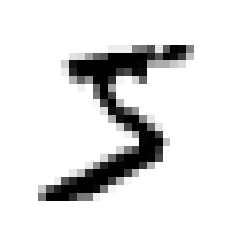

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit_image = X[0].reshape(28, 28) #grab an instance of a vector, and reshape into 28x28 pixel array
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

Looks like a 5, let's see what the label says

In [7]:
y[0]

'5'

The label is a string, we perfer numbers, so let's cast y into integers

In [8]:
y = y.astype(np.uint8)

Saving figure more_digits_plot


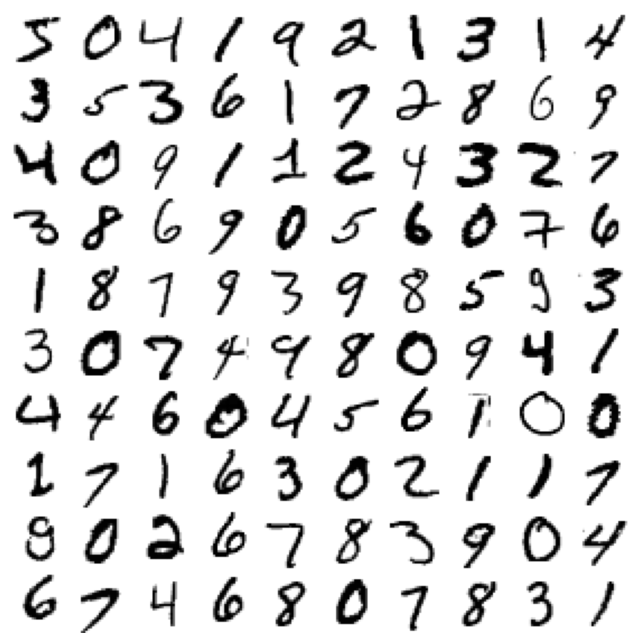

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation = "nearest")
    plt.axis("off")
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
plt.figure(figsize = (9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
save_fig("more_digits_plot")
plt.show()

Conveniently for us, the MNIST dataset is already split into train_set and test_set

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set has aleady been shuffled for us, which is good because this guarantees all cross-validation will be similar - we do not one fold to be missing some digits

## 1. Training a Binary Classifier

Let's simplify the problem for now and try to identify one digit - the number 5. This is an example of a binary classifier, capable of distinguishing between two classes - "5" and "not 5".

In [11]:
y_train_5 = (y_train == 5) #True for all 5s, and false for all other digits
y_test_5 = (y_test == 5)

Now let's pick a classifier and train it, a good place to start is *Stochastic Gradient Descent* (SGD)
> SGD relies on randomness during training, hence the name "stochastic"

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGD supports Linear Classifier with SGD training, by default it used SVM (Support Vector Machine)

In [13]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

## 2. Performance Measures
- A good way to measure performance is to use cross-validation

## 2.1 K-fold cross validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits = 3, random_state = 42) 
#split the data in 3 folds, each fold is used once as validation set while the rest (k-1) folds are used in training
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) 
    #Clone does a deep copy of the model in an estimator without actually copying attached data. 
    #It yields a new estimator with the same parameters that has not been fit on any data.
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred)) 

C:\Users\xf20985\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, scoring = "accuracy", cv = 3)

array([0.95035, 0.96035, 0.9604 ])

Over 90%!! Looks amazing, doesn't it? But let's look at a dumb classifier

In [16]:
from sklearn.base import BaseEstimator 
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, scoring = "accuracy", cv = 3)

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy again! That is because only about 10% of the images are 5s, if you always guess that an image is not a 5, you will be right 90% of the time. This demonstrates why accuracy is not the preferred performance measure for classifiers, especially when dealing with skewed datasets(i.e. when some classes are more frequent than others)

## 2.2 Confusion Matrix 
- The general idea is to count the number of times instances of class A are classified as class B

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
#Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation,
#but instead of returning the evaluation scores, it returns the predictions on each test fold

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in the matrix represent an actual class, while each column represent a predicted class. 

In [20]:
pd.DataFrame(confusion_matrix(y_train_5, y_train_pred), index = ["Not 5", "5"], columns = ["Not 5 Pred", "5 Pred"])

,Not 5 Pred,5 Pred
Not 5,53892,687
5,1891,3530


1. One metric to look at is the precision = TP/(TP + FP) (TP = True Positive, FP = False Positive)
2. It is often used with a metric named *recall*, also called *sensitivity* or *true positive rate* = TP/(TP + FN) (FN is False Negative)

> ### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530/(3530 + 687)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) # == 3530/(3530 + 1891)

0.6511713705958311

In summary, when the model claims an image is a 5, it is correct 83.7% of the time. Moreover, it only detects 65.1% of 5s

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Increasing precision reduces recall, and vice versa. This is called the precision-recall tradeoff.

> To understand this tradeoff, we need to understand how SGDClassifier makes classification decisions. It computes a score based on a decision function, if a score is greater than a threshold, it assigns an instance to a positive class, or else it assigns it to a negative class. 

> Scikit-learn does not let you set the threshold directly, but it gives you access to the decision scores it used to make predictions. Instead of the `predict()` method, we can call its `decision_function()` method, which returns a score for each instance, and then make predictions based on the scores using any threshold we want

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function") # return decision scores
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

Saving figure precision_recall_vs_threshold_plot


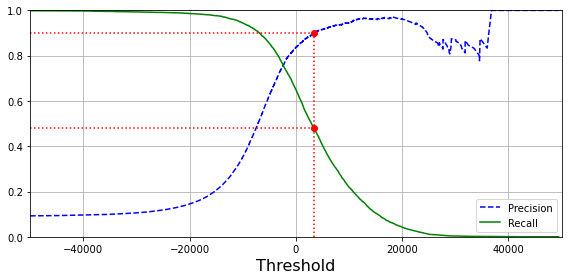

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.legend(loc="best")
    plt.xlabel("Threshold", fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # argmax returns the indices of the maximum values along an axis.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall

In [28]:
(y_train_pred == (y_scores > 0)).all() #Default threshold is 0

True

Another way to select a good tradeoff is to plot precision directly against recall

Saving figure precision_vs_recall_plot


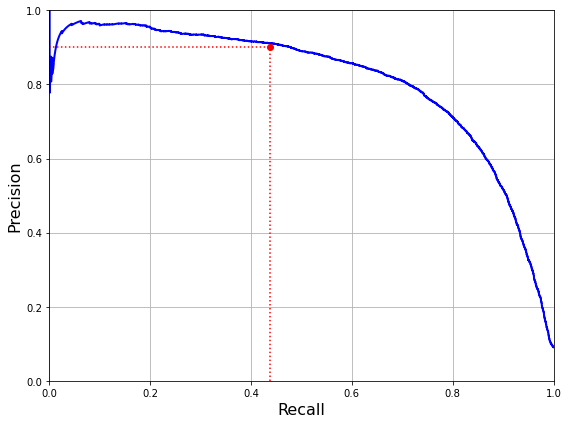

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
#precisions >= 0.90 returns a boolean array, argmax returns the first largest value, which is the first True.
#Therefore, it returns the position of True value - in this case the position of threshold value when precision = 90
threshold_90_precision

3370.0194991439557

Now, to make predictions, instead of calling the classifier's predict() method, we can just run

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

> ### The ROC Curve (Receiver Operating Characteristic)

The ROC curve is another common tool used with binary classifiers. It plots true positive rate (sensitivity) against false positive rates (1 - specificity)

In [33]:
#To plot the ROC curve, we first need to compute the TPR and FPR for the various threshold values, using the roc_curve function
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


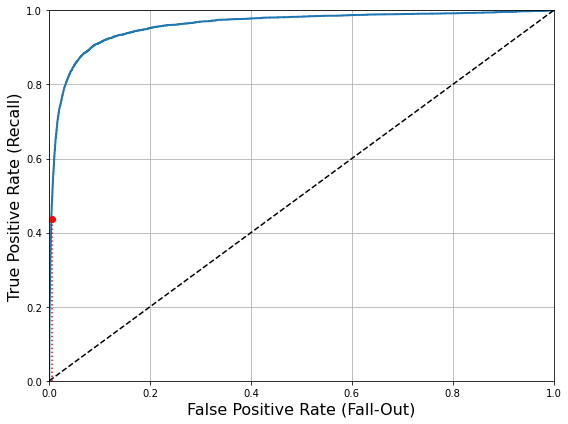

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], "k--") #dashed diagonals
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize = 16)
    plt.ylabel("True Positive Rate (Recall)", fontsize = 16)
    plt.grid("True")

    
plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

Once again there's a tradeoff, the higher the recall, the more false positives the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible

One way to compare classifiers is to compare the area under curve (AUC). A perfect classifier will have ROC AUC equal to 1, a purely random one will have  an AUC of 0.5

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
#The predict_proba method returns an array containing a row per instance and a column per class,
#each containing the probability that the given instance belongs to the given class
y_scores_forest = y_probas_forest[:, 1] #Take the probability of the positive class

In [37]:
pd.DataFrame(y_probas_forest, columns = ["is 5", "not 5"]).head(5)

,is 5,not 5
0,0.11,0.89
1,0.99,0.01
2,0.96,0.04
3,1.00,0.00
4,0.99,0.01


Saving figure roc_curve_comparison_plot


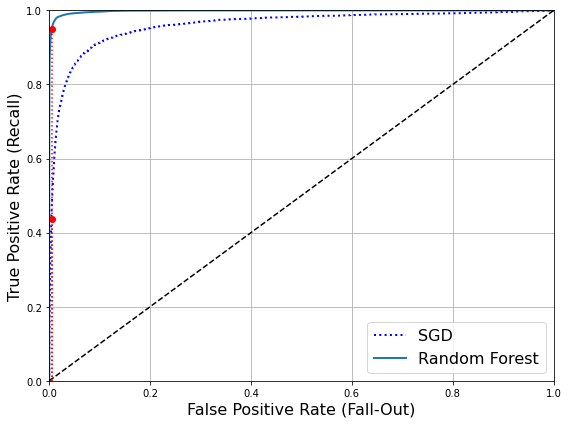

In [38]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

The Random Forest Classifier ROC curve looks much better, and it's much closer to the top-left corner (AUC ~ 1)

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [41]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Not bad! 99% precision and 86.6% recall.

## 3. Multiclass Classification
- see page 102

In [42]:
sgd_clf.fit(X_train, y_train) 
#Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
#classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction. Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [43]:
some_digits_score = sgd_clf.decision_function([some_digit])
some_digits_score

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [44]:
np.argmax(some_digits_score)

3

In [45]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
sgd_clf.classes_[np.argmax(some_digits_score)]

3

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor.

In [47]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovo_clf.estimators_)

45

In [49]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes.

In [50]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better.

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

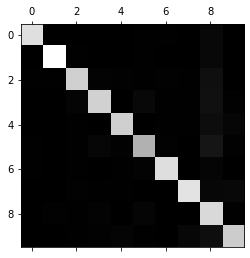

In [54]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

The confusion matrix looks quite good, since most images are on the main diagonal, which means they are classified correctly

Now let's focus the plot on errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so that we compare error rates instead of absolute number of errors

In [55]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [56]:
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

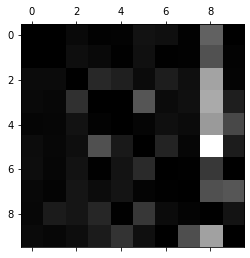

In [57]:
np.fill_diagonal(norm_conf_mx, 0) # Fill diagonal with 0 to show only errors
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

1. The column for 8 s quite bright, which means that many images get misclassified as 8
2. The row for class 8 is not that bad, so 8s in general get properly classified as 8
3. 3s and 5s get confused in both directions

We can:
> - Gather more training data that looks like 8 but are not
> - Engineer new features (e.g. count number of loops)
> - Preprocess the image (e.g. Scikit-Image, Pillow, OpenCV) to make some patterns stand out more

Let's look at examples of 3s and 5s

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] #Correctly classified as 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] #3 incorrectly classified as 5
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] #Correcly classified as 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] #5 incorrectly classified as 3

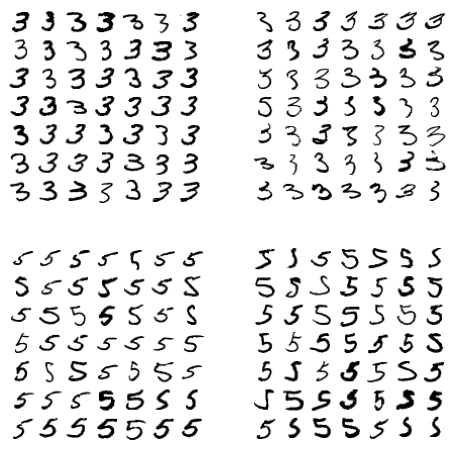

In [59]:
plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:49], images_per_row = 7)
plt.subplot(222); plot_digits(X_ab[:49], images_per_row = 7)
plt.subplot(223); plot_digits(X_bb[:49], images_per_row = 7)
plt.subplot(224); plot_digits(X_ba[:49], images_per_row = 7)
plt.show()

The main reason for misclassification is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too
rotated. This will probably help reduce other errors as well.

## 4. Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one tag per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classification system.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier() #KNeighborClassifier supports multilabel classification
knn_clf.fit(X_train, y_multilabel) #Notice that it outputs two labels
knn_clf.predict([some_digit])

array([[False,  True]])

In [61]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
#f1_score(y_multilabel, y_train_knn_pred, average = "macro") #This can take hours

This assumes that all labels are equally important, which may not be the case. One option is to give each label a weight equal to its support (The number of instances with that target label) with `average = "weighted"`

## 5. Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)

In [62]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


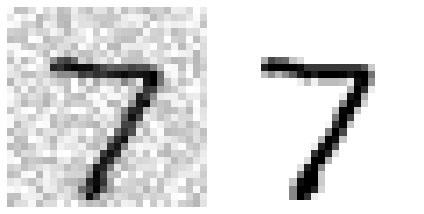

In [63]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, on the right is the clean target image. Now let's train the classifier to clean the image

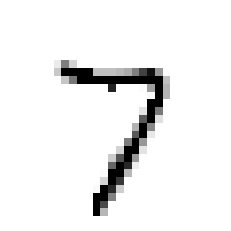

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercises

> 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf_97 = KNeighborsClassifier(n_neighbors = 5)
knn_clf_97.fit(X_train, y_train)
test_digit = X_train[0]
knn_clf_97.predict([test_digit])

array([5], dtype=uint8)

In [ ]:
#from sklearn.model_selection import GridSearchCV

#param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

#knn_clf = KNeighborsClassifier()
#grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
#grid_search.fit(X_train, y_train) #This will take more than a day to run

> 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [72]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1]) #Reshpe -1 returns a shape of 28x28 = 784

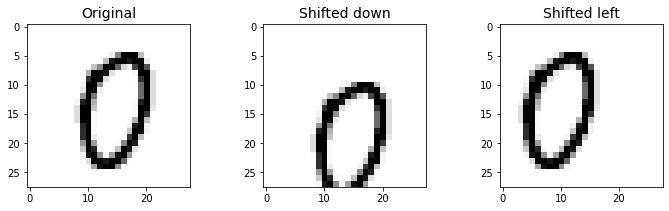

In [73]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [78]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [79]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [83]:
knn_clf = KNeighborsClassifier(n_neighbors = 4, weights = "distance")
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors = 4, weights = "distance")
knn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = knn_clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)